In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numpy import sqrt, exp, sinh
#from scipy import constants, special
from scipy import constants, special
plt.rcParams['figure.figsize'] = 16, 9

# Scattering computation

### Implement Numerov 

You can simply use the code developed in the previous exercise

In [2]:
def numerov_step(k0, k1, k2, psi0, psi1, dx):
    """compute psi2 via a single numerov step"""
    dx_sqr = dx**2
    c0 = (1 + 1/12. * dx_sqr * k0)
    c1 = 2 * (1 - 5/12. * dx_sqr * k1)
    c2 = (1 + 1/12. * dx_sqr * k2)
    return (c1 * psi1 - c0 * psi0) / c2

In [3]:
def numerov(ks, psi0, psi1, dx):
    """compute psis = [psi0, psi1, psi2, ...] for ks = [k0, k1, ...] via iterated numerov steps"""
    n = len(ks)
    psis = np.zeros(n, dtype=np.complex128)
    psis[0] = psi0
    psis[1] = psi1
    for i in range(2, n):
        psis[i] = numerov_step(ks[i-2], ks[i-1], ks[i], psis[i-2], psis[i-1], dx)
    return psis

### Discretization parameters

In [4]:
r_min = 0.5
r_max = 5
r_steps = 1000
rs, dr = np.linspace(r_min, r_max, r_steps, retstep=True)

l_max = 10
ls = np.arange(0, l_max+1)
l_colors = colors = cm.rainbow(ls / float(l_max))

Es = np.linspace(0.1, 3.5, 200)


### Lennard-Jones potential

In [5]:
eps = 5.9

def V_LJ(r):
    """r is in units of sigma, result is in meV"""
    s = (1./r)**6
    return eps * (s**2 - 2*s)

### Effective potential

In [6]:
hbar_sqr_over_2m = 1/6.12

def V_eff(l):
    def V(r):
        return V_LJ(r) + hbar_sqr_over_2m * l*(l+1) / r**2
    return V


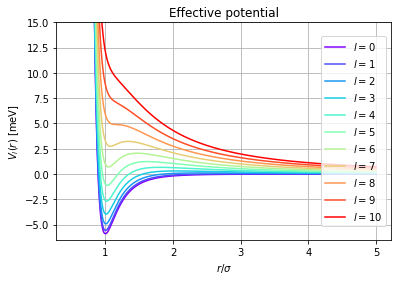

In [8]:
plt.title(r'Effective potential')
plt.xlabel(r'$r / \sigma$')
plt.ylabel(r'$V_l(r)$ [meV]')
plt.ylim(-6.5, 15)
for l, color in zip(ls, l_colors):
    plt.plot(rs, V_eff(l)(rs), label='$l = %d$' % l, color=color)
plt.grid()
plt.legend(loc='right')
plt.savefig('potential.pdf')
plt.show()

### Asymptotic solution for $r \rightarrow 0$

In [9]:
C = np.sqrt(eps / (25 * hbar_sqr_over_2m))

def inner_solution(r):
    return np.exp(-C * r**(-5))

### Sperical Bessel functions 

In [11]:
def bessel_j(l, x):
    #return special.spherical_jn(l, x)[0][-1]
    return special.spherical_jn(l, x)

def bessel_n(l, x):
    #return special.spherical_yn(l, x)[0][-1]
    return special.spherical_yn(l, x)

assert np.isclose(bessel_j(5, 1.5), 6.69620596e-4)
assert np.isclose(bessel_n(5, 1.5), -94.2361101)

### Phase shift

In [12]:
def delta(E, l):
    # integrate radial solution using numerov
    ks = (E - V_eff(l)(rs)) / hbar_sqr_over_2m
    psi0 = inner_solution(r_min)
    psi1 = inner_solution(r_min + dr)
    psis = numerov(ks, psi0, psi1, dr)
    
    # compute phase shift
    r1, r2 = r_max - dr, r_max
    u1, u2 = psis[-2:]
    K = (r1*u2) / (r2*u1)
    k = np.sqrt(E / hbar_sqr_over_2m)
    numerator = K * bessel_j(l, k*r1) - bessel_j(l, k*r2)
    denominator = K * bessel_n(l, k*r1) - bessel_n(l, k*r2)
    return np.arctan((numerator / denominator).real)


### Partial scattering cross section for fixed $l$

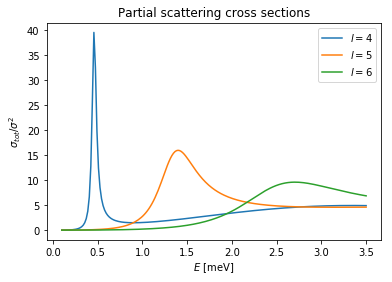

In [13]:
def partial(E, l):
    k_sqr = E / hbar_sqr_over_2m
    return 4*np.pi/k_sqr * (2*l + 1) * np.sin(delta(E, l))**2

plt.title('Partial scattering cross sections')
plt.xlabel('$E$ [meV]')
plt.ylabel(r'$\sigma_{tot} / \sigma^2$')
for l in [4, 5, 6]:
    plt.plot(Es, [partial(E, l) for E in Es], label="$l = %d$" % l)
plt.legend()
plt.savefig('partial.pdf')
plt.show()

### Total scattering cross section for various values of $l_{\max}$

In [ ]:
partials = [np.array([partial(E, l) for E in Es]) for l in range(l_max + 1)]

In [ ]:
plt.title('Total scattering cross section for various values of the cutoff $l_{\max}$')
plt.xlabel('$E$ [meV]')
plt.ylabel(r'$\sigma_{tot} / \sigma^2$')
for l_max, color in zip(ls, l_colors):
    plt.plot(Es, sum(partials[l] for l in range(l_max+1)), label="$l_{\max} = %d$" % l_max, color=color)
plt.legend()
plt.savefig('total.pdf')
plt.show()
